In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Cityscapes
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import cv2
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes
import torchvision.transforms as transforms
import torch.nn.functional as F

CITYSCAPES_ROOT = "../cityscapes"
input_size = (520, 1040)  # height, width

# -----------------------------
# TRAINID MAPPING
# -----------------------------
id_to_trainid = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255,
    5: 255, 6: 255, 7: 0,   8: 1,   9: 255,
    10: 255, 11: 2, 12: 3, 13: 4, 14: 255,
    15: 255, 16: 255, 17: 5, 18: 255, 19: 6,
    20: 7, 21: 8, 22: 9, 23: 10, 24: 11,
    25: 12, 26: 13, 27: 14, 28: 15,
    29: 255, 30: 255, 31: 16, 32: 17, 33: 18,
    -1: 255
}
valid_ids = list(range(19)) + [255]

# -----------------------------
# MASK TRANSFORM
# -----------------------------
def convert_to_train_ids(mask):
    mask_np = np.array(mask)
    mask_train = np.full(mask_np.shape, 255, dtype=np.uint8)
    for raw, train in id_to_trainid.items():
        mask_train[mask_np == raw] = train
    mask_train[~np.isin(mask_train, valid_ids)] = 255
    return torch.from_numpy(mask_train.astype(np.int64))

def mask_transform(mask):
    mask = convert_to_train_ids(mask)  # H,W
    mask = F.interpolate(
        mask.unsqueeze(0).unsqueeze(0).float(),
        size=input_size,
        mode="nearest"
    ).squeeze(0).squeeze(0).long()
    return mask

# -----------------------------
# IMAGE TRANSFORM
# -----------------------------
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(input_size)
])

# -----------------------------
# DATASETS & DATALOADERS
# -----------------------------
train_ds = Cityscapes(
    CITYSCAPES_ROOT, split="train", mode="fine", target_type="semantic",
    transform=train_transform, target_transform=mask_transform
)

val_ds = Cityscapes(
    CITYSCAPES_ROOT, split="val", mode="fine", target_type="semantic",
    transform=train_transform, target_transform=mask_transform
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained DeepLabV3+
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)

# Replace classifier for 19 classes
model.classifier[4] = nn.Conv2d(256, 19, kernel_size=1)

# Replace BatchNorm with GroupNorm in ASPP to avoid 1x1 issue
def replace_bn_with_gn(module):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            gn = nn.GroupNorm(num_groups=32, num_channels=child.num_features, eps=child.eps)
            setattr(module, name, gn)
        else:
            replace_bn_with_gn(child)

replace_bn_with_gn(model.classifier)  # only ASPP classifier

model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_11176/1526755489.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [4]:
from tqdm import tqdm

def compute_miou(pred, target, num_classes=19):
    pred = pred.flatten()
    target = target.flatten()

    mask = target != 255
    pred = pred[mask]
    target = target[mask]

    if pred.numel() == 0:
        return 0.0

    ious = []
    for cls in range(num_classes):
        pred_i = pred == cls
        target_i = target == cls

        intersection = (pred_i & target_i).sum().item()
        union = (pred_i | target_i).sum().item()

        if union == 0:
            ious.append(1.0)
        else:
            ious.append(intersection / union)

    return sum(ious) / len(ious)


def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4, num_classes=19):
    history = {"train_loss": [], "val_loss": [], "miou": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()

            # Mixed precision
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(imgs)["out"]
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})

        train_loss /= len(train_loader)

        # -----------------------------
        # VALIDATION
        # -----------------------------
        model.eval()
        val_loss = 0.0
        miou_total = 0.0

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)

                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(imgs)["out"]
                    loss = criterion(outputs, masks)

                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                miou_total += compute_miou(preds, masks)

        val_loss /= len(val_loader)
        miou_total /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["miou"].append(miou_total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"mIoU: {miou_total:.4f}")

    return model, history


# Run training
model, history = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=1e-4
)


Epoch 1/30: 100%|██████████| 1488/1488 [06:07<00:00,  4.05it/s, loss=0.149]


Epoch 1/30 | Train Loss: 0.3634 | Val Loss: 0.2549 | mIoU: 0.5829


Epoch 2/30: 100%|██████████| 1488/1488 [06:06<00:00,  4.06it/s, loss=0.143] 


Epoch 2/30 | Train Loss: 0.2195 | Val Loss: 0.2554 | mIoU: 0.5444


Epoch 3/30: 100%|██████████| 1488/1488 [06:06<00:00,  4.06it/s, loss=0.136] 


Epoch 3/30 | Train Loss: 0.1906 | Val Loss: 0.2134 | mIoU: 0.6057


Epoch 4/30: 100%|██████████| 1488/1488 [06:06<00:00,  4.07it/s, loss=0.11]  


Epoch 4/30 | Train Loss: 0.1649 | Val Loss: 0.2049 | mIoU: 0.6096


Epoch 5/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.173] 


Epoch 5/30 | Train Loss: 0.1511 | Val Loss: 0.1943 | mIoU: 0.6110


Epoch 6/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.221] 


Epoch 6/30 | Train Loss: 0.1365 | Val Loss: 0.1927 | mIoU: 0.6188


Epoch 7/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.0444]


Epoch 7/30 | Train Loss: 0.1273 | Val Loss: 0.2033 | mIoU: 0.6329


Epoch 8/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.146] 


Epoch 8/30 | Train Loss: 0.1164 | Val Loss: 0.1822 | mIoU: 0.6323


Epoch 9/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.129] 


Epoch 9/30 | Train Loss: 0.1141 | Val Loss: 0.1798 | mIoU: 0.6236


Epoch 10/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.0753]


Epoch 10/30 | Train Loss: 0.1051 | Val Loss: 0.1837 | mIoU: 0.6218


Epoch 11/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.117] 


Epoch 11/30 | Train Loss: 0.1068 | Val Loss: 0.2351 | mIoU: 0.6096


Epoch 12/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.08it/s, loss=0.0554]


Epoch 12/30 | Train Loss: 0.0955 | Val Loss: 0.1762 | mIoU: 0.6504


Epoch 13/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.08it/s, loss=0.0908]


Epoch 13/30 | Train Loss: 0.0915 | Val Loss: 0.1836 | mIoU: 0.6211


Epoch 14/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.07it/s, loss=0.0922]


Epoch 14/30 | Train Loss: 0.0825 | Val Loss: 0.1842 | mIoU: 0.6350


Epoch 15/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0767]


Epoch 15/30 | Train Loss: 0.0829 | Val Loss: 0.2072 | mIoU: 0.5952


Epoch 16/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0837]


Epoch 16/30 | Train Loss: 0.0846 | Val Loss: 0.2285 | mIoU: 0.5854


Epoch 17/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.074] 


Epoch 17/30 | Train Loss: 0.0746 | Val Loss: 0.1809 | mIoU: 0.6579


Epoch 18/30: 100%|██████████| 1488/1488 [06:05<00:00,  4.08it/s, loss=0.0829]


Epoch 18/30 | Train Loss: 0.0665 | Val Loss: 0.1882 | mIoU: 0.6477


Epoch 19/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0859]


Epoch 19/30 | Train Loss: 0.0726 | Val Loss: 0.2061 | mIoU: 0.6421


Epoch 20/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0777]


Epoch 20/30 | Train Loss: 0.0788 | Val Loss: 0.1965 | mIoU: 0.6301


Epoch 21/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0672]


Epoch 21/30 | Train Loss: 0.0664 | Val Loss: 0.1894 | mIoU: 0.6530


Epoch 22/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0617]


Epoch 22/30 | Train Loss: 0.0580 | Val Loss: 0.2064 | mIoU: 0.6496


Epoch 23/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0331]


Epoch 23/30 | Train Loss: 0.0600 | Val Loss: 0.2149 | mIoU: 0.6410


Epoch 24/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0727]


Epoch 24/30 | Train Loss: 0.0567 | Val Loss: 0.2340 | mIoU: 0.6304


Epoch 25/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0626]


Epoch 25/30 | Train Loss: 0.0747 | Val Loss: 0.1981 | mIoU: 0.6464


Epoch 26/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0633]


Epoch 26/30 | Train Loss: 0.0543 | Val Loss: 0.2000 | mIoU: 0.6534


Epoch 27/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0398]


Epoch 27/30 | Train Loss: 0.0564 | Val Loss: 0.2041 | mIoU: 0.6462


Epoch 28/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.09it/s, loss=0.0538]


Epoch 28/30 | Train Loss: 0.0568 | Val Loss: 0.2146 | mIoU: 0.6462


Epoch 29/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.09it/s, loss=0.0235]


Epoch 29/30 | Train Loss: 0.0498 | Val Loss: 0.2197 | mIoU: 0.6605


Epoch 30/30: 100%|██████████| 1488/1488 [06:04<00:00,  4.08it/s, loss=0.0484]


Epoch 30/30 | Train Loss: 0.0588 | Val Loss: 0.4520 | mIoU: 0.5603


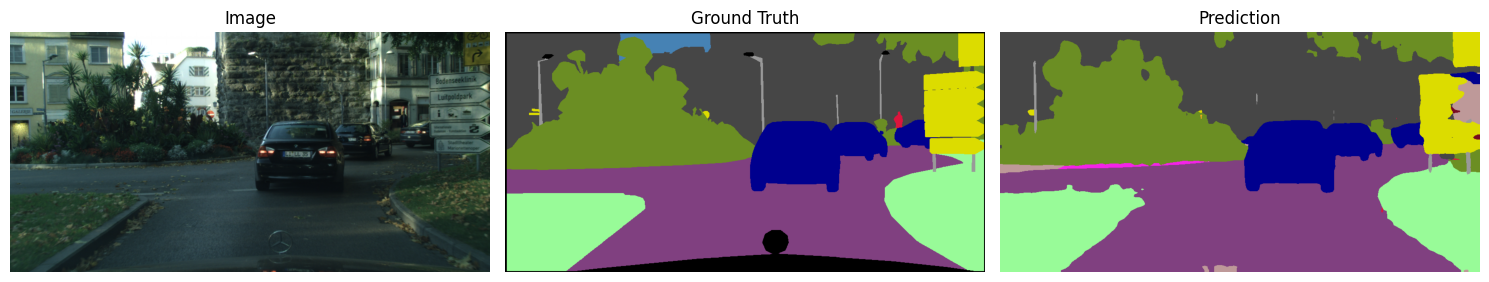

In [16]:
import numpy as np
import torch

# Cityscapes 19-class color palette
CITYSCAPES_COLORS = np.array([
    (128,  64, 128),   # 0: road
    (244,  35, 232),   # 1: sidewalk
    (70,   70,  70),   # 2: building
    (102, 102, 156),   # 3: wall
    (190, 153, 153),   # 4: fence
    (153, 153, 153),   # 5: pole
    (250, 170,  30),   # 6: traffic light
    (220, 220,   0),   # 7: traffic sign
    (107, 142,  35),   # 8: vegetation
    (152, 251, 152),   # 9: terrain
    (70, 130, 180),    # 10: sky
    (220,  20,  60),   # 11: person
    (255,   0,   0),   # 12: rider
    (0,     0, 142),   # 13: car
    (0,     0,  70),   # 14: truck
    (0,    60, 100),   # 15: bus
    (0,    80, 100),   # 16: train
    (0,     0, 230),   # 17: motorcycle
    (119,  11,  32),   # 18: bicycle
], dtype=np.uint8)

IGNORE_VALUE = 255                # Cityscapes void label
IGNORE_COLOR = (0, 0, 0)          # color to display ignore pixels

def decode_segmap(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()

    mask = mask.astype(np.int32)

    # Create output RGB
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Mask for valid labels
    valid_mask = (mask >= 0) & (mask < 19)

    # Apply valid colors
    rgb[valid_mask] = CITYSCAPES_COLORS[mask[valid_mask]]

    # Apply ignore/void color
    rgb[mask == IGNORE_VALUE] = IGNORE_COLOR

    return rgb


model.eval()

idx = 40  # choose any index
img, mask = val_ds[idx]   # img: (3,H,W), mask: (H,W)

with torch.no_grad():
    out = model(img.unsqueeze(0).to(device))["out"]  # <-- FIX
    pred = torch.argmax(out, dim=1).cpu().numpy()[0]

# Convert image and masks
img_np = img.permute(1, 2, 0).numpy()
gt_rgb = decode_segmap(mask.numpy())
pred_rgb = decode_segmap(pred)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_rgb)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_rgb)
plt.title("Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()
